# Introduction to Data Science
## Unsupervised methods
***

Read in some packages.

In [2]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = 14, 8

np.random.seed(36)

### Data
As usual, we will start by reading in some data. Today we will be looking at movie rating data that was derived from Tweets (https://github.com/sidooms/MovieTweetings). The data set consists of three files: `movies.dat`, `ratings.dat`, and `users.dat`. For our class tonight, we will only be looking at the first two files. Both of them are located in the `data` directory. These files **do not** have a header row at the top so we will manually set it.

In [4]:
# Read in the movies data
movies = pd.read_csv("data/movies.dat", names=['movie_id', 'movie_title', 'genre'], sep="\:\:")

# Movie ids don't start at 0 and some are missing, let's remap
movie_id_map = dict(zip(np.argsort(movies['movie_id'].unique())*-1, movies['movie_id'].unique()))

# Given the mapping, let's replace the values
movies = movies.replace({"movie_id": {v: k for k, v in movie_id_map.items()}})
movies['movie_id'] = movies['movie_id'] * -1

In [5]:
movies.head()

,movie_id,movie_title,genre
0,0,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short
1,1,La sortie des usines Lumière (1895),Documentary|Short
2,2,The Arrival of a Train (1896),Documentary|Short
3,3,Le manoir du diable (1896),Short|Horror
4,4,Le voyage dans la lune (1902),Short|Adventure|Fantasy


In [6]:
# Read in the ratings data
ratings = pd.read_csv("data/ratings.dat", names=['user_id', 'movie_id', 'rating', 'rating_timestamp'], sep="\:\:")

# User ids start at 1, let's bump them all down by 1
ratings['user_id'] = ratings['user_id'] - 1

# Make movie ids match the ones from our movie's data
ratings = ratings.replace({"movie_id": {v: k for k, v in movie_id_map.items()}})
ratings['movie_id'] = ratings['movie_id'] * -1

# Put our mapping back in order
movie_id_map = dict((key*-1, value) for (key, value) in movie_id_map.items())

In [7]:
ratings.head()

,user_id,movie_id,rating,rating_timestamp
0,0,2958,10,1381620027
1,0,6656,10,1379466669
2,1,10878,8,1412178746
3,1,11292,8,1394818630
4,1,12039,7,1389963947


Now that we have our two data files loaded in and cleaned, we can create one data frame that joins both of them together.

In [8]:
movies_ratings = pd.merge(movies, ratings, on="movie_id").drop(['genre', 'rating_timestamp'], axis=1)

In [9]:
movies_ratings.head()

,movie_id,movie_title,user_id,rating
0,0,Edison Kinetoscopic Record of a Sneeze (1894),20903,5
1,1,La sortie des usines Lumière (1895),35627,10
2,2,The Arrival of a Train (1896),28455,10
3,3,Le manoir du diable (1896),7207,6
4,4,Le voyage dans la lune (1902),7396,8


This data can be represented as a movie-by-user matrix (kind of like the document-by-word matrices we saw in our text class). In this new matrix, we can let movies be the rows, users are the columns, and each cell is filled in with a rating.

In [10]:
data = sparse.csr_matrix((movies_ratings['rating'], (movies_ratings['movie_id'], movies_ratings['user_id'])), 
                         shape=(max(movies_ratings['movie_id'])+1, max(movies_ratings['user_id'])+1))

### Dimensionality reduction
This matrix has many dimensions. If, for example, we wanted to plot this data onto a 2 dimensional space, we would have to find some way of reducing are large number of dimensions. One way of doing this is with SVD.

In [11]:
svd = TruncatedSVD(2)

In [12]:
svd.fit(data)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [13]:
components = svd.transform(data)

With our data reduced to 2 components, we can visualize it easily.

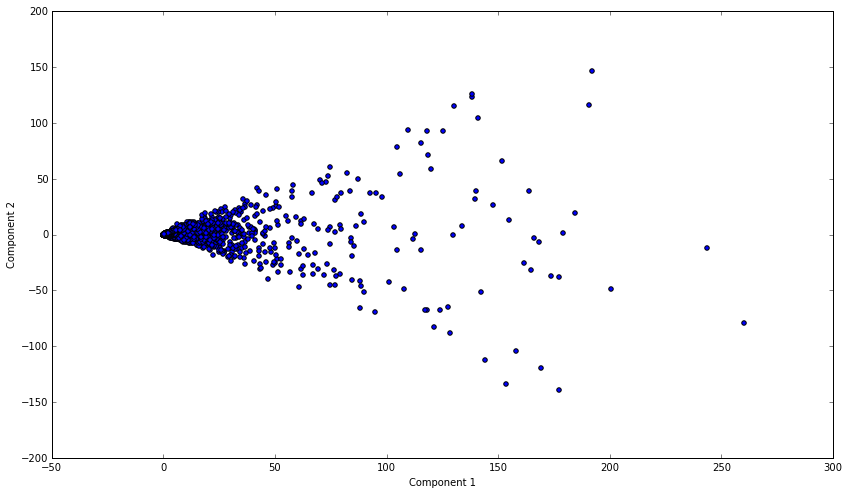

In [14]:
plt.scatter(components[:,0], components[:,1])
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

Very messy... We can write a few small functions to pick out a few of our favorite movies and see what's around them!

In [15]:
def movie_search(movie_name):
    return movies.loc[(movies['movie_title'].str.match('(.*' + movie_name + '.*)').str.len() > 0)]

In [16]:
def movie_plotter(movie_id, components, x_buffer=3, y_buffer=2):
    x = components[movie_id][0]
    y = components[movie_id][1]

    xs = [x - x_buffer, x + x_buffer]
    ys = [y - y_buffer, y + y_buffer]

    plt.scatter(components[:,0], components[:,1])
    plt.xlim(xs)
    plt.ylim(ys)

    for x, y, title in zip(components[:,0], components[:,1], movies['movie_title']):
        if x >= xs[0] and x <= xs[1] and y >= ys[0] and y <= ys[1]:
            plt.text(x, y, title)

In [28]:
movie_search("The Matrix")

,movie_id,movie_title,genre
7613,7613,The Matrix (1999),Action|Adventure|Sci-Fi
8589,8589,The Matrix Reloaded (2003),Action|Sci-Fi
8668,8668,The Matrix Revolutions (2003),Action|Adventure|Sci-Fi


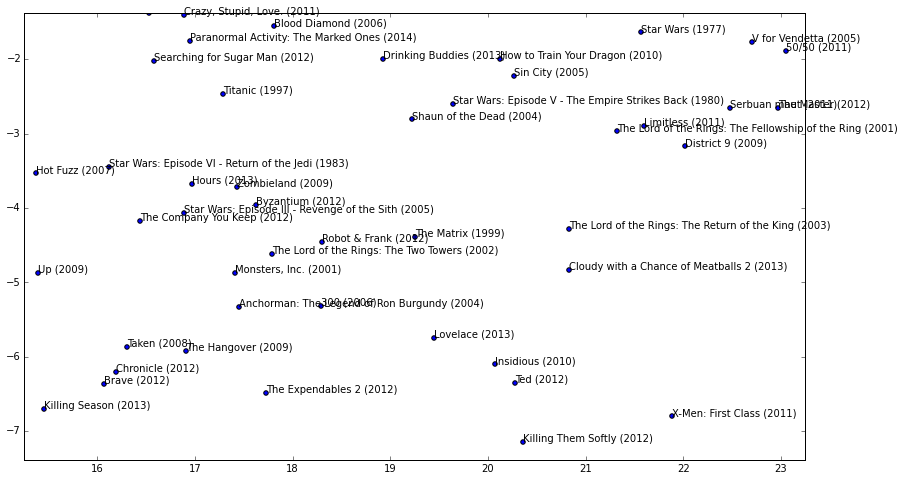

In [29]:
movie_plotter(7613, components, 4, 3)